In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from infra.model_base import ModelBase
from infra.train import Metrics, Evaluator
from infra.dataset import AutoencoderDataset
from infra.clstm import Autoencoder, ResidualAutoencoder
from tqdm import tqdm
from pytorch_msssim import MS_SSIM, SSIM
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np

np.random.seed(42)
torch.manual_seed(42)
sns.set_theme()

In [3]:
class MS_SSIM_Loss(MS_SSIM):
    def forward(self, img1, img2):
        return 100*(1 - super(MS_SSIM_Loss, self).forward(img1, img2))

class SSIM_Loss(SSIM):
    def forward(self, img1, img2):
        return 100*(1 - super(SSIM_Loss, self).forward(img1, img2))
num_epochs = 25
train_examples = 2
test_examples = 2

In [4]:
training_data = AutoencoderDataset(
    "./temp/processed",
    torch.device("cpu"),
    count=train_examples,
    train_mode=True,
    deterministic=True
)
testing_data = AutoencoderDataset(
    "./temp/processed",
    torch.device("cpu"),
    count=test_examples,
    train_mode=False,
    deterministic=True
)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=2)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=2)


In [51]:
loss_fn = MS_SSIM_Loss(data_range=1.0, channel=1, win_size=7, size_average=True)
# loss_fn = torch.nn.MSELoss()
model = ResidualAutoencoder(checkpoint_dir="./checkpoint/rautoencoder")
optim = torch.optim.Adam(model.parameters(), lr=1e-12, weight_decay=0)
metrics = Metrics()

In [52]:
def train(
    model: ModelBase,
    loss_fn,
    optimizer: torch.optim.Optimizer,
    train: torch.utils.data.DataLoader,
    validation: torch.utils.data.DataLoader,
    metrics: Metrics,
    num_epochs,
    verbose=True,
):
    predictor = lambda x: torch.argmax(x, dim=1)
    evaluator = Evaluator(model, loss_fn, optimizer, predictor, metrics)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.95)
    for epoch in range(num_epochs):
        if verbose:
            print("═" * 10 + f" Epoch {epoch+1} " + "═" * 10)
            print("Training pass: ", end="")
        train_loss, _ = evaluator.train_epoch(train, verbose)
        if verbose:
            print("Validation pass: ", end="")
        val_loss, _ = evaluator.validate(validation, verbose)
        if verbose:
            print(f"Train Loss: {train_loss}, Val Loss: {val_loss}")
        # if epoch % 5 == 0:
        #     model.save(name=f"epoch{epoch}")
        scheduler.step()
    return (
        evaluator.train_loss,
        evaluator.train_metrics,
        evaluator.val_loss,
        evaluator.val_metrics,
    )

<AxesSubplot:>

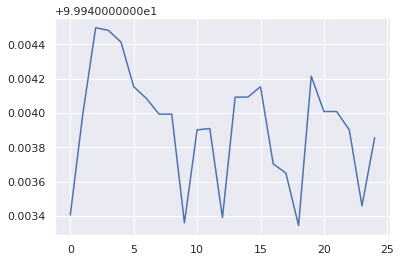

In [53]:
train_loss, _, val_loss, _ = train(
    model, loss_fn, optim, train_loader, test_loader, metrics, num_epochs, verbose=False
)
# model.save(name="finalepoch")
sns.lineplot(x=torch.arange(0, len(train_loss)), y=train_loss)

In [12]:
model = ResidualAutoencoder(checkpoint_dir="./checkpoint/rautoencoder")
model.load(id="finalepoch")
model.eval()
print("")

In [13]:
testing_data = AutoencoderDataset(
    "./temp/processed",
    torch.device("cpu"),
    count=1000,
    train_mode=False,
)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=1)

In [14]:
train_iter = iter(test_loader)

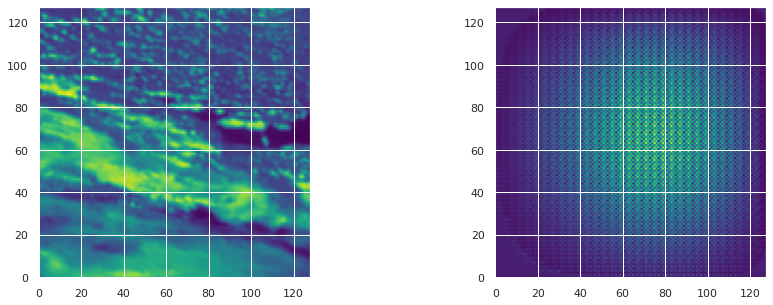

In [22]:
X,_ = next(train_iter)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
with torch.no_grad():
    pred = model(X)
    pred = pred.detach().numpy()
ax[0].imshow(X[0,0], cmap='viridis', origin='lower')
ax[1].imshow(pred[0,0], cmap='viridis', origin='lower')

In [156]:
model.save(name="basic_autoencoder", embedder_weight=model.embedder.state_dict(), generator_weight=model.generator.state_dict())

In [5]:
checkpoint = torch.load("./checkpoint/autoencoder/basic_autoencoder.pth")

In [6]:
from infra.embedders import Embedder, Generator
gen = Generator()
gen.load_state_dict(checkpoint["generator_weight"])
gen.eval()

Generator(
  (block1): UStridedConvReluBN(
    (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
    (pool): Upsample(scale_factor=2.0, mode=nearest)
  )
  (block2): UStridedConvReluBN(
    (conv): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
    (pool): Upsample(scale_factor=2.0, mode=nearest)
  )
  (block3): UStridedConvReluBN(
    (conv): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
    (pool): Upsample(scale_factor=2.0, mode=nearest)
  )
  (block4): UStridedConvReluBN(
    (conv): ConvTrans

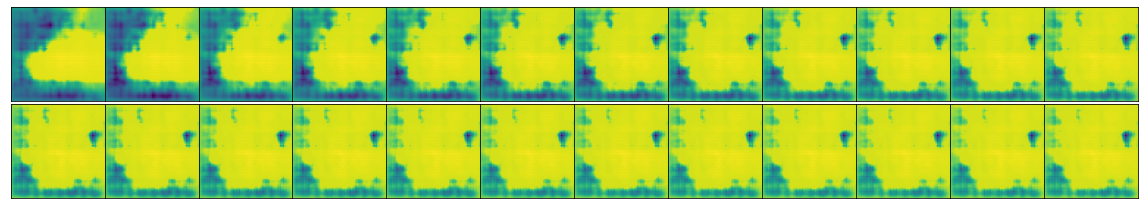

In [24]:
input = torch.arange(0,312,13).view(-1,1).to(torch.float32).broadcast_to((24, 512))
with torch.no_grad():
    pred = gen(input)
    pred = pred.detach().numpy()
fig, (ax1, ax2) = plt.subplots(2, 12, figsize=(16,3))
for i in range(12):
    ax1[i].imshow(pred[i, 0], cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

for i in range(12):
    ax2[i].imshow(pred[i+12, 0], cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)


In [15]:
print(input)

tensor([[319.0682, 212.8804, 351.5488,  ..., 132.8015, 605.6831, 828.6755],
        [274.5874, 685.7153, 614.5807,  ..., 164.8231,  60.7247, 553.4180],
        [760.6554, 182.3037, 536.6441,  ..., 658.3361, 640.0183, 710.3837],
        ...,
        [ 51.6145, 592.6568, 964.7009,  ...,  86.5209, 545.3732, 640.7700],
        [178.4031, 150.0344, 348.3219,  ..., 477.9293, 479.4843, 951.5173],
        [686.4905, 337.3297, 942.9430,  ...,  25.3143, 617.9805, 745.8087]])
